<a href="https://colab.research.google.com/github/OhJin-Soo/ktb_ai/blob/main/no_data_augmented_almond_clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
mahyeks_almond_varieties_path = kagglehub.dataset_download('mahyeks/almond-varieties')

print('Data source import complete.')

Using Colab cache for faster access to the 'almond-varieties' dataset.
Data source import complete.


In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

import os

import tensorflow as tf
from tensorflow import keras

import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
IMG_SIZE = 224

In [10]:
def create_data(base_dir):
    x = []
    y = []
    index_label = dict()
    label_index = dict()

    for i, j in enumerate(os.listdir(base_dir)):
        label = os.path.join(base_dir, j)
        index_label[i] = j
        label_index[j] = i
        for k in os.listdir(label):
            im_path = os.path.join(label, k)
            image = cv2.imread(im_path)
            image = cv2.resize(image, (IMG_SIZE,IMG_SIZE))
            x.append(image)
            y.append(i)

    x = np.array(x)
    y = np.array(y)
    x = x/255.0
    y = keras.utils.to_categorical(y, len(index_label))
    return x, y, label_index, index_label

In [11]:
base_dir = "/kaggle/input/almond-varieties/dataset"

In [12]:
x, y, label_index, index_label = create_data(base_dir)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

In [14]:
resnet = keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = resnet(inputs, training=True)   # 증강 제거
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1000, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(len(index_label), activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=30,
    validation_data=(x_test, y_test),
    callbacks=[
        keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy"),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
    ]
)

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.6916 - loss: 24.5240

39/39 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.6943 - loss: 24.1706 - val_accuracy: 0.2340 - val_loss: 16007509.0000
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8807 - loss: 1.5361

39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.8809 - loss: 1.5232 - val_accuracy: 0.2628 - val_loss: 2.8527
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9493 - loss: 0.3915 - val_accuracy: 0.2628 - val_loss: 49.9891
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9567 - loss: 0.2627 - val_accuracy: 0.2628 - val_loss: 26.5431
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9804 - loss: 0.0800 - val_accuracy: 0.2628 - val_loss: 13.0390
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9714 - loss: 0.0945 - val_accuracy: 0.2628 - val_loss: 11.7862
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9640 - loss: 0.0902 - val_accuracy: 0.2628 - val_loss: 19.0081
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9814 - loss: 0.0405 - val_accuracy: 0.2628 - val_loss: 14.8183


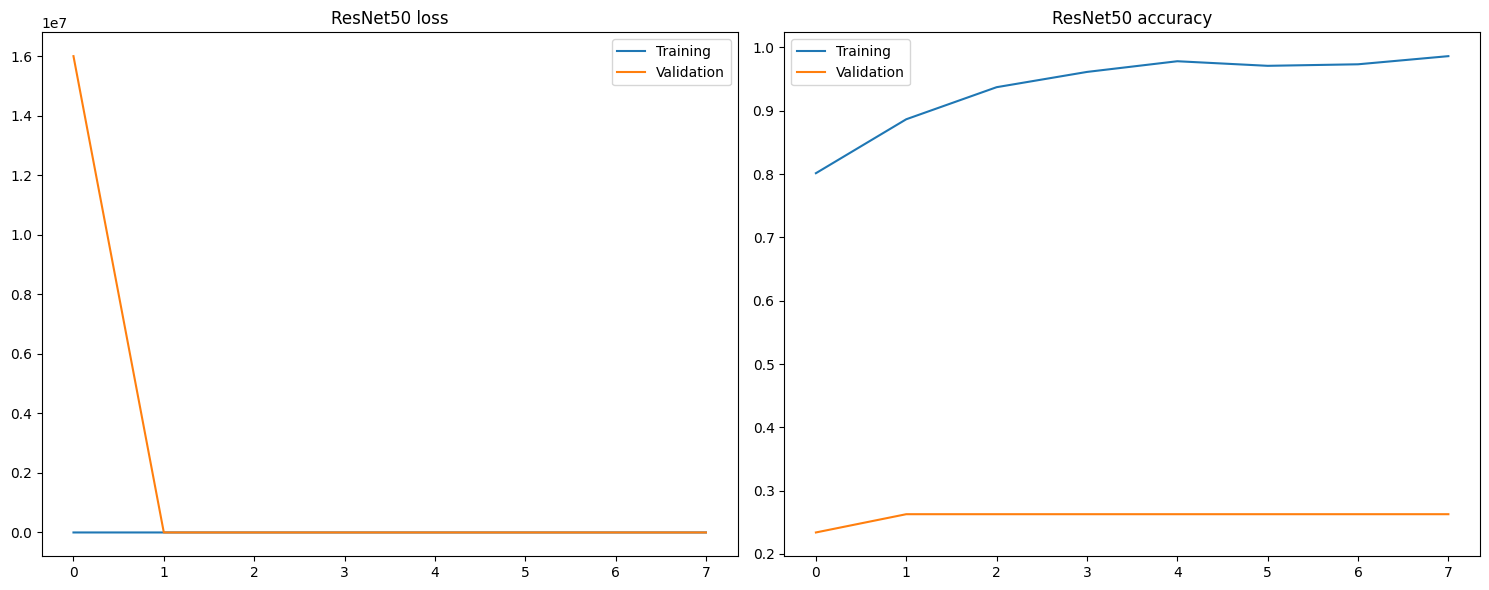

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

index = 0

axes[index].plot(history.history["loss"], label="Training")
axes[index].plot(history.history["val_loss"], label="Validation")
axes[index].set_title("ResNet50 loss")
axes[index].set_xlabel("")
axes[index].set_ylabel("")
axes[index].legend()

index += 1

axes[index].plot(history.history["accuracy"], label="Training")
axes[index].plot(history.history["val_accuracy"], label="Validation")
axes[index].set_title("ResNet50 accuracy")
axes[index].set_xlabel("")
axes[index].set_ylabel("")
axes[index].legend()

plt.tight_layout()
plt.show()

In [17]:
def predict(img):
    label = model.predict(img.reshape(1, IMG_SIZE, IMG_SIZE, 3))
    pred = label.argmax()
    return pred, label[0][pred], index_label[pred]

In [18]:
truth = []
predicted = []
probabilities = []
labels = []

for i in range(x_test.shape[0]):
    img_arr = x_test[i]
    truth += [y_test[i].argmax()]
    pred, prob, label = predict(img_arr)
    predicted += [pred]
    probabilities += [prob]
    labels += [label]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━

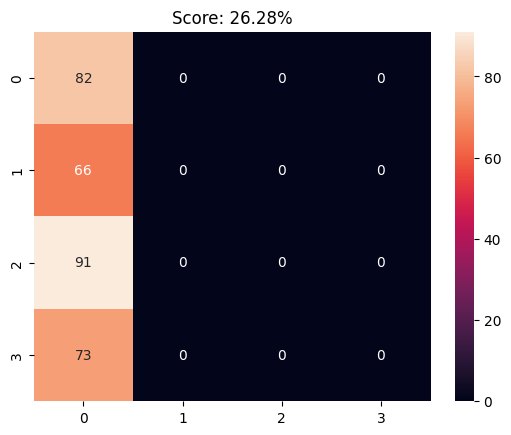

              precision    recall  f1-score   support

           0       0.26      1.00      0.42        82
           1       0.00      0.00      0.00        66
           2       0.00      0.00      0.00        91
           3       0.00      0.00      0.00        73

    accuracy                           0.26       312
   macro avg       0.07      0.25      0.10       312
weighted avg       0.07      0.26      0.11       312



In [19]:
score = accuracy_score(truth, predicted)
cm = confusion_matrix(truth, predicted)
report = classification_report(truth, predicted)
sns.heatmap(cm, annot=True)
plt.title("Score: {}%".format(round(score*100, 2)))
plt.show()
print(report)

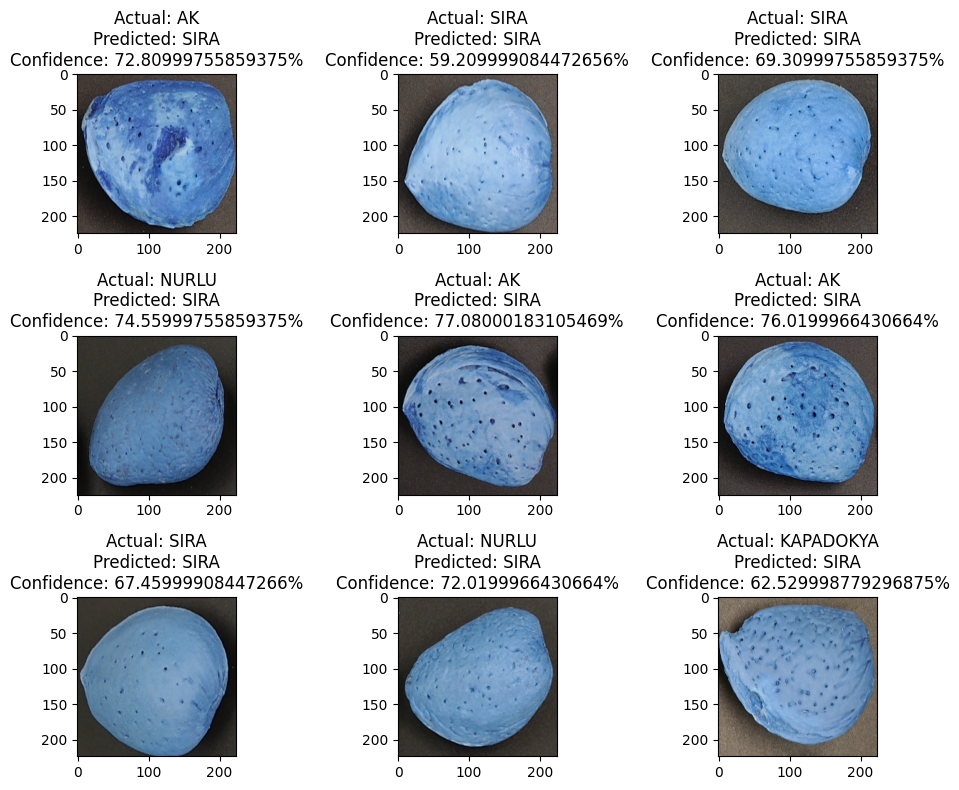

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
index = 0

for i in range(3):
    for j in range(3):
        axes[i][j].imshow(x_test[index])
        axes[i][j].set_title("Actual: {}\nPredicted: {}\nConfidence: {}%".format(index_label[truth[index]],
                                                                                labels[index],
                                                                                round(probabilities[index]*100, 2)))
        index += 1
plt.tight_layout()
plt.show()